In [365]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### CHAPTER 3: The Impact of Healthcare Competition on Hospital Quality for Uninsured Patients

### DATA
I primarily use the HCUP State Inpatient Database (SID) files for the years between 2012 and 2016 that contain patient discharges for the following states: Arkansas, Florida, Mississippi, New York, Utah, and Vermont. I also use the American Hospital Association’s Annual Survey of Hospitals (AHA) to obtain hospital characteristics and I merge HCUP SID with AHA data using AHA hospital identifier. I supplement the data with Area Health Resource File (AHRF), and American Community Survey (ACS). I only include general short-term hospitals to obtain potentially preventable hospital admissions which are known as ambulatory care sensitive conditions (ACSCs) at the hospital level. 

The HCUP SID data includes patient characteristics and clinical information such as diagnosis and procedures on each discharge from hospitals in participating states. Each discharge also contains payer information and the source of admissions. The data is provided by Agency for Healthcare Research and Quality(AHRQ) along with SAS software that identifies prevention quality indicators (PQIs) for ACSCs based on diagnosis and procedure codes. I use the same algorithm as in the SAS software to obtain PQIs for hospitals in the data sample and use those rates as dependent variables for the analysis. 

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
import statsmodels.formula.api as smf
#from statsmodels.sandbox.regression.gmm import IV2SLS
from linearmodels import IV2SLS
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.iv.results import compare 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from pydot import graph_from_dot_data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import warnings
warnings.filterwarnings('ignore')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.impute import SimpleImputer

# Set ipython's max row display to 100
pd.set_option('display.max_rows', 500)

# Set iPython's max column width to 60
pd.set_option('display.max_columns', 2000)

pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Prevention Quality Indicators
The data sample for the analysis contains more than 6 million discharges per year for 6 states. Following the AHRQ approach, I exclude patients who are younger than 18, or transferred from another institution, or have MDC 14 (Pregnancy, Childbirth, and the Puerperium). Then I identify discharges only having the following ambulatory care sensitive conditions:

    -TAPQ01 "PQI 01 Diabetes Short-Term Complications Admission Rate (Numerator)"
    -TAPQ02 "PQI 02 Perforated Appendix Admission Rate (Numerator)"
    -TAPQ03 "PQI 03 Diabetes Long-Term Complications Admission Rate (Numerator)"
    -TAPQ05 "PQI 05 Chronic Obstructive Pulmonary Disease (COPD) or Asthma in Older Adults Admission Rate (Numerator)"
    -TAPQ07 "PQI 07 Hypertension Admission Rate (Numerator)"
    -TAPQ08 "PQI 08 Heart Failure Admission Rate (Numerator)"
    -TAPQ10 "PQI 10 Dehydration Admission Rate (Numerator)"
    -TAPQ11 "PQI 11 Bacterial Pneumonia Admission Rate (Numerator)"
    -TAPQ12 "PQI 12 Urinary Tract Infection Admission Rate (Numerator)"
    -TAPQ14 "PQI 14 Uncontrolled Diabetes Admission Rate (Numerator)"
    -TAPQ15 "PQI 15 Asthma in Younger Adults Admission Rate (Numerator)"
    -TAPQ16 "PQI 16 Lower-Extremity Amputation among Patients with Diabetes Rate (Numerator)"
    
I constructed two different outcome variables at the hospital level derived from HCUP data that I use for this paper.

    1.PQI ratio for all discharges: the sum of all patients with PQI0 / all discharges in time-period
    2.PQI ratio for uninsured patients: the sum of uninsured patients with PQI/ all uninsured discharges (PAY1 = 4, self-pay)

Since some patients may have more than one ACSC and the ratio for a hospital may be higher than 1. I present the mean values of each dependent variable along with all variables in the next table. The final data is at the hospital level and the time is fiscal quarter to be consistent with the time in the HCUP SID data.


#### Summary Statistics

In [2]:
# import the data and prepare it for analysis.

df = pd.read_stata("C:/Users/mehme/Google Drive/share_with_dell/Chapter_3_analysis.dta")

## Create a medicaid expansion variable. Of the six states, only Mississippi and Florida have not expanded medicaid coverage since 2014. 
df['medicaidexp'] = np.where((df['mstate'] == "NY") & (df['year'] >= 2014), 1, 
                             np.where( (df['mstate'] == "AR") & (df['year'] >= 2014), 1,
                             np.where( (df['mstate'] == "UT") & (df['year'] >= 2014), 1,
                             np.where( (df['mstate'] == "VT") & (df['year'] >= 2014), 1,
                             0))))

df['sysmember'] = np.where(df['mhsmemb'] == 1.0, 1, 0)

df['insurer_hhi_MSAcode'] =df['insurer_hhi_MSAcode']/10000

df1 = df[['DSHOSPID','year', 'DQTR', 'PQI_ratio_all', 'PQI_ratio_uninsured', 'PQI_ratio_p_insured', 'hhi_hosp', 'insurer_hhi_MSAcode', 'casemixindex', 'medianincome','poverty_pct', 'employment_pct', 'uninsured_pct', 'medicaidexp', 'nonprofit', 'forprofit', 'nonfederal', 'ICD','population_msa', 'insurance_private_pct', 'Food_SNAP_recip_' ,'primcare_phys_', 'Active_mds_', 'mstate', 'cbsacode_new','cbsatype_new', 'nonprofittotal', 'forprofittotal', 'nonfederaltotal' , 'majorteaching', 'hosp_profit_status', 'price', 'numeric_quarter', 'total_quarterly_discharge', 'uninsured_quarterly_discharge', 'Total_uninsured_PQI', 'insured_quarterly_discharge', 'Total_insured_PQI', 'mloczip', 'sysmember']].set_index(['DSHOSPID', 'year', 'DQTR']).sort_index()
df1['hhi_ratio'] = df1['hhi_hosp'] / df1['insurer_hhi_MSAcode']
df1['ICD'] = df1['ICD'].astype("category")  
df1['nonprofit'] = df1['nonprofit'].astype("category")
df1['forprofit'] = df1['forprofit'].astype("category")
df1['nonfederal'] = df1['nonfederal'].astype("category")
df1['medicaidexp'] = df1['medicaidexp'].astype("category")
df1['cbsatype_new'] = df1['cbsatype_new'].astype("category")
df1['cbsacode_new'] = df1['cbsacode_new'].astype("object")
#df1['hosp_profit_status'] = df1['hosp_profit_status'].astype("category") 
df1['majorteaching'] = df1['majorteaching'].astype("category")
df1['log_medianincome'] = np.log2(df1['medianincome'])
shape = df1.shape
print("the number of observations and variables is:", shape)
df1.describe(include=[np.number])


the number of observations and variables is: (10210, 39)


,PQI_ratio_all,PQI_ratio_uninsured,PQI_ratio_p_insured,hhi_hosp,insurer_hhi_MSAcode,casemixindex,medianincome,poverty_pct,employment_pct,uninsured_pct,population_msa,insurance_private_pct,Food_SNAP_recip_,primcare_phys_,Active_mds_,nonprofittotal,forprofittotal,nonfederaltotal,price,total_quarterly_discharge,uninsured_quarterly_discharge,Total_uninsured_PQI,insured_quarterly_discharge,Total_insured_PQI,sysmember,hhi_ratio,log_medianincome
count,10210.00,9693.00,10187.00,8381.00,7108.00,10114.00,8368.00,8368.00,8368.00,8368.00,8372.00,8368.00,8372.00,8372.00,8372.00,7964.00,7964.00,7964.00,9801.00,10210.00,9693.00,9693.00,10187.00,10187.00,10210.00,5696.00,8368.00
mean,19.36,15.32,19.75,0.46,0.14,1.49,53361.53,12.04,5.51,14.24,3764946.43,63.83,111676.07,520.79,2202.86,57.13,13.04,13.12,5042.79,2441.53,131.71,18.29,2223.55,394.58,0.68,2.73,15.67
std,13.85,14.20,14.24,0.25,0.06,0.27,10917.96,3.64,1.20,4.75,6464174.86,7.59,115947.69,494.42,2224.23,68.37,18.68,18.92,5358.87,2159.08,176.92,29.18,1984.06,461.39,0.47,1.49,0.30
min,0.00,0.00,0.00,0.09,0.07,0.71,26407.00,5.50,2.30,4.30,18975.00,38.00,2137.00,4.88,7.04,0.00,0.00,0.00,20.02,1.00,1.00,0.00,1.00,0.00,0.00,0.54,14.69
25%,10.31,6.90,10.52,0.24,0.08,1.31,46706.00,10.40,4.80,10.80,183974.00,59.70,20442.00,95.76,312.00,8.00,0.00,0.00,2470.30,762.25,24.00,3.00,702.00,115.00,0.00,1.67,15.51
50%,14.92,11.90,15.13,0.44,0.12,1.48,50183.00,11.20,5.40,14.40,724385.00,64.90,75069.00,322.00,1300.00,28.00,6.00,4.00,4042.78,1854.00,69.00,9.00,1646.00,258.00,1.00,2.15,15.61
75%,26.18,20.00,26.77,0.63,0.17,1.66,63543.00,13.20,6.20,17.70,2915582.00,68.10,184252.22,820.54,3127.11,64.00,16.00,12.00,6128.14,3563.00,166.00,21.00,3265.50,490.00,1.00,3.55,15.96
max,100.00,200.00,100.00,1.00,0.40,2.42,93144.00,33.80,13.00,29.00,19508904.00,82.10,447502.12,1683.80,6547.86,212.00,68.00,56.00,112522.11,13040.00,1546.00,443.00,11773.00,4684.00,1.00,9.82,16.51


The table above set out the summary statistics on the data sample and it shows that the average PQI rate for uninsured patients is nearly 15% of total uninsured discharges and is lower than the PQI rate for all patients. Of the six states, more hospitals are located in Florida and New York State (Graph 1) and 60% of total hospitals in six states have nonprofit status while 25% are forprofit hospitals.

the number of hospitals in the data is: 538


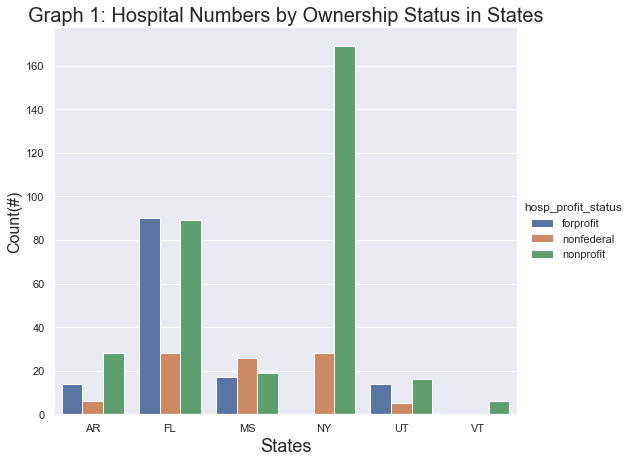

In [3]:
unique = df1.reset_index()['DSHOSPID'].nunique()
print("the number of hospitals in the data is:", unique)

elma = df1.reset_index().groupby(['mstate', 'hosp_profit_status'])['DSHOSPID'].nunique()
elma = elma.reset_index()


# viz
sns.set_theme()
g = sns.catplot(x='mstate',
                y= 'DSHOSPID',
                hue='hosp_profit_status',
                data=elma,
                kind='bar',
                ci=None,
                height = 6,
                aspect=1.2
                   )
g.set_axis_labels("States", "Count")
plt.title("Graph 1: Hospital Numbers by Ownership Status in States", fontsize=20)
plt.xlabel('States', fontsize=18)
plt.ylabel('Count(#)', fontsize=16)
plt.show()

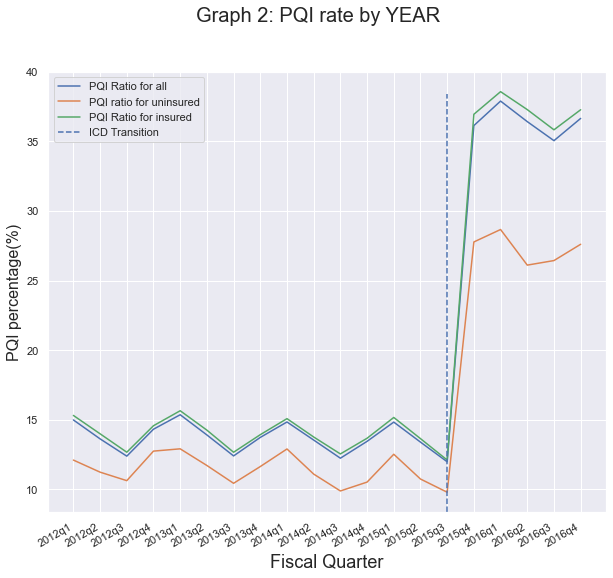

In [4]:
trend = df.groupby('numeric_quarter')['PQI_ratio_all', 'PQI_ratio_uninsured' ,'PQI_ratio_p_insured'].mean()
#trend1 = df.groupby('numeric_quarter')['total_quarterly_discharge'].mean().reset_index()
#trend.plot(title = 'Graph 1: PQI rate by YEAR',  xlabel = 'Fiscal Quarter', ylabel = 'PQI percentage(%)', figsize=(10,9), grid = True); 
#trend1["total_quarterly_discharge"].plot(kind="bar", secondary_y=True, style="g")

mylabels =['PQI Ratio for all', 'PQI ratio for uninsured','PQI Ratio for insured','ICD Transition']
sns.set_theme()
fig = plt.figure(figsize=(10,9))
ax = plt.plot(trend)
fig.suptitle('Graph 2: PQI rate by YEAR', fontsize=20)
plt.xlabel('Fiscal Quarter', fontsize=18)
plt.ylabel('PQI percentage(%)', fontsize=16)
fig.autofmt_xdate()
plt.axvline(x='2015q3', ymax=0.95, label='ICD Transition', linestyle='--')
plt.legend(labels = mylabels)
plt.show();

It is worth noting that ICD9 codes were the national diagnosis coding system in the US before The Department of Health and Human Services (HHS) required hospitals to use ICD10 diagnosis coding as of October 1, 2015. The transition of ICD10 occurred in the last quarter of 2015 and As of 2015 q4, all discharges are coded in ICD-10. Compared to ICD9, the ICD10 coding system includes a higher level of detail and incorporates new codes into the health care system. The graph 2 shows that the trend for each PQI rate increases dramatically in the last financial quarter of 2015. Since the transition requirement was applied to all hospitals, I control for the change in the analysis rather than constructing an adjusted PQI rate for each hospital. In the sensitivity analysis, I limit the data sample to only observations with ICD9. 

The Graph 3 below shows how the PQI rate for each group of patients is distributed and also shows the relationship between two groups of patients by ownership status of hospitals. Both PQI rates for uninsured and insured patients are distributed skew right. The rate for uninsured patients is higher at nonprofit hospitals compared to other types of hospitals. As the sample size for nonprofit hospitals accounts for %60 of total hospital discharges from 2012 to 2016 in six states, it is probable to expect more uninsured patients to visit nonprofit hospitals compared to other types of hospitals.

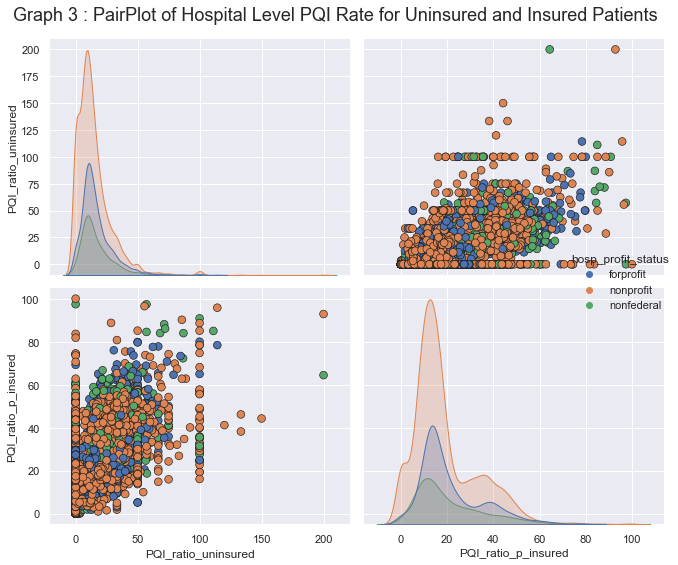

In [5]:
sns.set_theme()
sns.pairplot(df, hue="hosp_profit_status", vars=['PQI_ratio_uninsured' ,'PQI_ratio_p_insured'], diag_kind = 'kde',  
             plot_kws = { 'alpha': 1, 's': 60, 'edgecolor': 'k'}, size = 4
); plt.suptitle('Graph 3 : PairPlot of Hospital Level PQI Rate for Uninsured and Insured Patients', size = 18);
plt.tight_layout() 

#### Competition Measure
Using the HCUP SID data, I estimated the predicted Herfindahl-Hirschman Index(HHI) for each hospital which is derived from predicted market shares as I adopt Kessler and McClellan approach (Kessler and McClellan, 2000). As I discussed in Appendix A (***attach it to the latex document later***); due to the endogeneity of HHIs, I avoid defining the health care market based on geographical area for competition measure by estimating a demand model based on relative travel distances of hospital visits. For the demand model, I select all nonfederal general medical and surgical hospitals with nonrural Medicare patients within 80 minutes of driving from a patient location to a chosen hospital. The index is estimated between 0-1 with a higher value considering less competitive hospital. 

For insurers, I calculate the HHI with shares of commercial health plan in the defined market including both fully and self-insured enrollments at metropolitan market area per year since I do not observe each patient's insurance type for either discharge data or at the population level. The index ranges from 1 (perfect competition) to 10000 (a monopoly); however, I divide the index by 10000 to be consistent with Insurer HHI calculation for analysis purposes.    



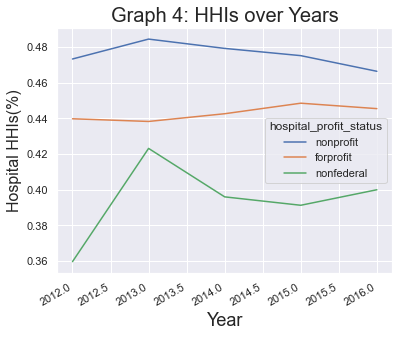

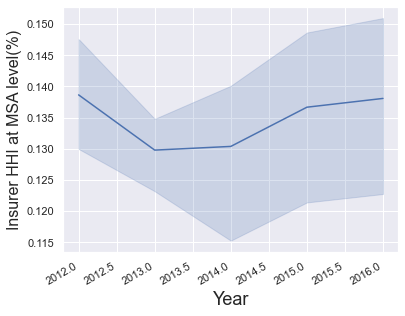

In [6]:
trend1 = df.groupby(['year', 'hospital_profit_status'])["hhi_hosp", "insurer_hhi_MSAcode"].mean().reset_index()

sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
fig = plt.figure(figsize=(6,5))
sns.lineplot(x="year", y="hhi_hosp",
             hue="hospital_profit_status", 
             data=trend1);
plt.title("Graph 4: HHIs over Years", fontsize = 20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Hospital HHIs(%)', fontsize=16)
fig.autofmt_xdate()

fig = plt.figure(figsize=(6,5))
sns.lineplot(x="year", y="insurer_hhi_MSAcode", 
             data=trend1)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Insurer HHI at MSA level(%)', fontsize=16);
fig.autofmt_xdate()

The graph 4 shows how hospital HHIs and insurer HHHs at the MSA level vary over time and across hospital ownership types. There is a noticeable increase for nonfederal and nonprofit hospital HHIs by 2013; however, it decreases for these types of hospitals. On the contrary, the trend of insurer HHIs follows an opposite direction to Hospital HHIs trend over time. I also examine the relationship between hospital and insurer HHIs in the Graph 5 to observe whether insurer and hospital HHIs are correlated and how each hospital ownership type is located in a different market concentration. As the graph shows, for-profit hospitals are more competitive firms and mostly located in moderately competitive insurer markets. Hospital ownership types are more normally distributed in terms of hospital HHIs (slightly right-skewed); however, the distribution of the location of different hospitals based on insurer competitiveness is highly right-skewed. It means that the majority of hospitals are located at either relatively moderate or unconcentrated insurer markets.  

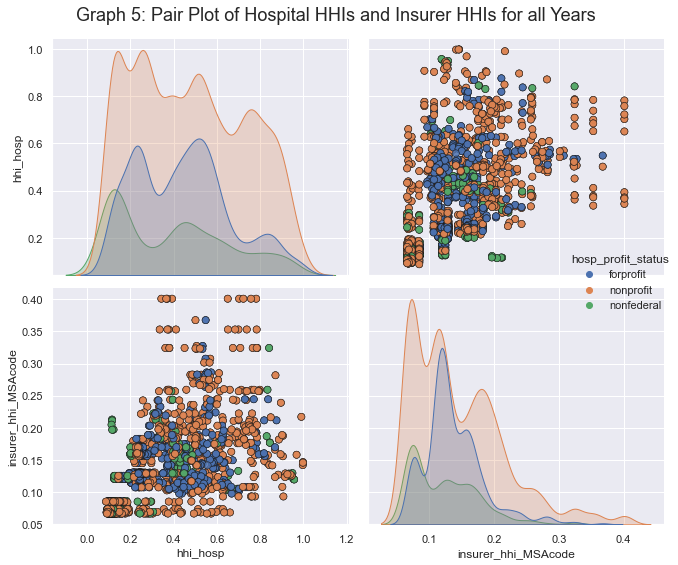

In [7]:
sns.pairplot(df, hue="hosp_profit_status", vars=["hhi_hosp", "insurer_hhi_MSAcode"], diag_kind = 'kde',  
             plot_kws = { 'alpha': 0.6, 's': 50, 'edgecolor': 'k'}, size = 4); 
plt.suptitle('Graph 5: Pair Plot of Hospital HHIs and Insurer HHIs for all Years', size = 18);
plt.tight_layout();


The scatter plot in the Graph 5 and Graph 6 indicates that the correlation of both HHIs is positive but slightly moderate ($\rho$ = 0.51).  (<font color='red'>Maybe it is better to talk about the complex relationship of hospital and insurer market power briefly. Talk with Prof. Cuellar</font>)

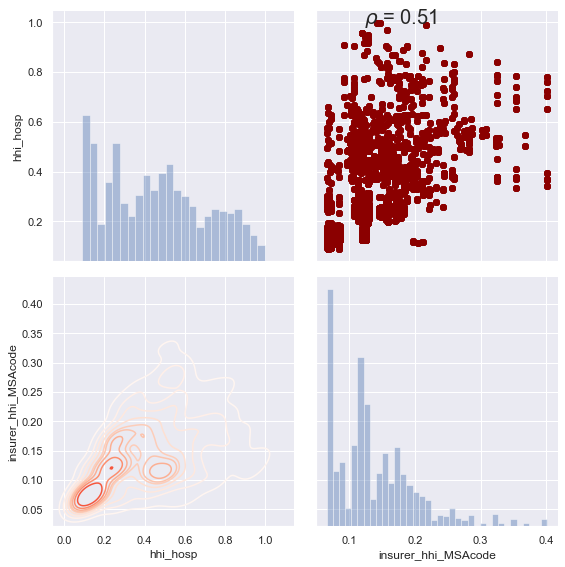

In [8]:
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = x.corr(y)
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# Create a pair grid instance
grid = sns.PairGrid(data= df,
                    vars = ["hhi_hosp", "insurer_hhi_MSAcode"], height = 4)

# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid.map_diag(sns.distplot, kde=False)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');

#### Econometric Specification

The main focus of this study is to examine the hospital quality for uninsured patients given the market power of hospital and insurer concentration. I begin with a basic regression framework in which PQI rate (R) is a function of hospital and insurer HHIs along with both hospital and market-level characteristics.

\begin{gather*}
R^m_{ht}= \Phi_ht + \alpha_{h} +  \beta HHI_{ht} + \Gamma HHI_{it} + \theta X_{ht} + \zeta Z_t + \varepsilon^m_ht
\end{gather*}  

$R^m_{ht}$ defines the type of PQI ratio, $R^m$, at hospital $h$ in time $t$ and $\Phi_{ht}$ is the constant that is specific to each hospital $h$ at time $t$ while $\alpha_{h}$ is hospital fixed effects. $\beta$ and $\Gamma$ coefficients present the competition index of hospitals and insurers at the market level. $X$ includes the hospital characteristics such as ownership and teaching status while $Z$ is for market-level characteristics such as poverty and income level, employment rate.  I also add the ICD10 version dummy variable to control for the ICD transition. Some hospitals attract more patients and provide higher quality due to market size/higher market share. For that reason, I include all-payer case-mix in the model to control for hospital performance as a risk-adjustment. $\beta$ and $\Gamma$ capture to what extend the PQI rate changes with the market power of hospital and insurer market concentration.

In the second model, I estimate the model with IV for insurer HHI. I use population estimates and private health insured population as an instrument for insurer HHI while I use predicted market shares of the hospital for HHI. The model allows me to exploit the variation of PQI rates of hospitals in a different locations to observe how it changes with market concentration. In the third and final model, I also add hospital fixed effects to analyze the variation of the hospital's PQI rate among patients with different insurance status within the hospital.


In [10]:
df2 = df1.reset_index()

#### PQI_ratio_all 
#OLS
model_ols = IV2SLS.from_formula('PQI_ratio_all ~ 1 + hhi_hosp + insurer_hhi_MSAcode + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year)', df2)
ols1 = model_ols.fit() # robust HCV
#IV
model_iv = IV2SLS.from_formula('PQI_ratio_all ~ 1 + hhi_hosp + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + [insurer_hhi_MSAcode ~ population_msa + insurance_private_pct]', df2)
iv1 = model_iv.fit() # robust HCV

#### PQI_ratio_uninsured
#OLS
model_ols = IV2SLS.from_formula('PQI_ratio_uninsured ~ 1 + hhi_hosp + insurer_hhi_MSAcode + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year)', df2)
ols2 = model_ols.fit() # robust HCV
#IV
model_iv = IV2SLS.from_formula('PQI_ratio_uninsured ~ 1 + hhi_hosp + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + [insurer_hhi_MSAcode ~ population_msa + insurance_private_pct]', df2)
iv2 = model_iv.fit() # robust HCV



# compare model results based on linearmodels
res = {'OLS1':ols1,'IV1':iv1,'OLS2':ols2,'IV2':iv2}
print("TABLE 2")
print(compare(res, precision='std_errors', stars=bool))
#print(compare(res, precision='std-errors', stars=bool))


### Post-estimation results

# Tests for IV specification 
# (1) Durbin's test of exogeneity
print("Durbin's test of exogeneity")
print(iv1.durbin())      # iv1.durbin(['c1'])

# (2) Wu-Hausman test of exogeneity
print("Wu-Hausman test of exogeneity")
print(iv1.wu_hausman())  # iv1.wu_hausman(['c1'])

# Wooldridge's regression test of exogeneity
print("Wooldridge's regression test of exogeneity")
print(iv1.wooldridge_regression)

# Wooldridge's score test of exogeneity
print("Wooldridge's score test of exogeneity")
print(iv1.wooldridge_score)

# Wooldridge's score test of overidentification
print("Wooldridge's score test of overidentification")
print(iv1.wooldridge_overid)

# Sargan's test of overidentification
print("Sargan's test of overidentification")
print(iv1.sargan)

# First Stage Diagnostics
print('First Stage Diagnostics')
print(iv1.first_stage)


TABLE 2
                                                 Model Comparison                                                 
                                      OLS1                     IV1                    OLS2                     IV2
------------------------------------------------------------------------------------------------------------------
Dep. Variable                PQI_ratio_all           PQI_ratio_all     PQI_ratio_uninsured     PQI_ratio_uninsured
Estimator                              OLS                 IV-2SLS                     OLS                 IV-2SLS
No. Observations                      4867                    4867                    4707                    4707
Cov. Est.                           robust                  robust                  robust                  robust
R-squared                           0.7199                  0.7175                  0.3939                  0.3904
Adj. R-squared                      0.7189                  0.7165      

I present the result of both OLS and IV models for two dependent variables in the Table-2 above. The first two columns show the result for the PQI ratio of all patients while the third and fourth columns show the PQI ratio of uninsured patients. The hospital HHI coefficient from both models is positive and statistically significant. The magnitude of hospital HHI coefficient is higher with a t-value of 10 compared to the PQI ratio of uninsured patients' coefficient. It shows that the PQI ratio for all patients increases by 0.76 percentile for every 10-percentile increase in hospital-specific HHI. The HHI's marginal effect for PQI ratio of uninsured is nearly 0.04 percentile for each 10-percentile increase in hospital HHI. 

The insurer HHI is negative and statistically significant in both OLS and IV models for all patients. Although the empirical relationship between health insurance and health has mixed results, both the direction and magnitude of the insurer HHI coefficient imply that the PQI ratio of all patients decreases by 2.8 percentile for every 10-percentile increase in insurer HHI once the HHI is instrumented. On the contrary, I do not observe the same effect for uninsured patients. The OLS estimate of the HHI coefficient is not statistically significant; however, its direction becomes positive once I instrument for insurer HHI. As the market concentration increases for insurers by 10-percentile, the PQI rate for uninsured patients also increases nearly 2 percentile. 

I add the case-mix index in both models to control for the hospital quality conditional on the severity level of hospital procedures since some high-quality hospitals may attract more patients with chronic problems. The Case-mix variable, therefore, allows me to risk-adjust the model to some extent. As it is expected the PQI ratios for both patient groups decrease if the patient-severity of hospitals increases. It is worth noting that the decrease is slightly less for uninsured patients.

Table 2 also presents a noticeable result about hospital characteristics. The coefficient for teaching hospital status is positive and significant with a t-value of 2.5 in the IV model with all patients sample; however, it turns negative and only marginally significant (at 0.10 p-value with t-value of -1.90). Being a part of a system member increases the PQI ratio of uninsured patients while its coefficient is statistically significant for all patients. Lastly for-profit status of the hospital does not have a meaningful relationship with the PQI rate for uninsured patients. The federal status coefficient shows that uninsured patients tend to seek health care in federal hospitals, at the same time the coefficient is not statistically significant for all patients.

In [11]:
ols1 = IV2SLS.from_formula('PQI_ratio_all ~ insurer_hhi_MSAcode : hhi_hosp + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year)', data = df2).fit()
model_iv = IV2SLS.from_formula('PQI_ratio_all ~ 1 + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + [insurer_hhi_MSAcode:hhi_hosp ~ population_msa:hhi_hosp + insurance_private_pct:hhi_hosp]', df2)
iv1 = model_iv.fit()

## interaction
ols2 = IV2SLS.from_formula('PQI_ratio_uninsured ~ insurer_hhi_MSAcode : hhi_hosp + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year)', data = df2).fit()
model_iv = IV2SLS.from_formula('PQI_ratio_uninsured ~ 1 + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + [insurer_hhi_MSAcode:hhi_hosp ~ population_msa:hhi_hosp + insurance_private_pct:hhi_hosp]', df2)
iv2 = model_iv.fit()

#res = {'OLS1':ols1,'IV1':iv1,'OLS2':ols2,'IV2':iv2}
res = {'IV1':iv1,'IV2':iv2}
print('TABLE 3')
print(compare(res, precision='std-errors', stars=bool))
#print(compare(res, precision='std-errors', stars=bool))
print(".......................................")

### Post-estimation results

# Tests for IV specification 
# (1) Durbin's test of exogeneity
print("Durbin's test of exogeneity")
print(iv1.durbin())      # iv1.durbin(['c1'])

# (2) Wu-Hausman test of exogeneity
print("Wu-Hausman test of exogeneity")
print(iv1.wu_hausman())  # iv1.wu_hausman(['c1'])

# Wooldridge's regression test of exogeneity
print("Wooldridge's regression test of exogeneity")
print(iv1.wooldridge_regression)

# Wooldridge's score test of exogeneity
print("Wooldridge's score test of exogeneity")
print(iv1.wooldridge_score)

# Wooldridge's score test of overidentification
print("Wooldridge's score test of overidentification")
print(iv1.wooldridge_overid)

# Sargan's test of overidentification
print("Sargan's test of overidentification")
print(iv1.sargan)

# First Stage Diagnostics
print('First Stage Diagnostics')
print(iv1.first_stage)



TABLE 3
                                         Model Comparison                                         
                                                              IV1                              IV2
--------------------------------------------------------------------------------------------------
Dep. Variable                                       PQI_ratio_all              PQI_ratio_uninsured
Estimator                                                 IV-2SLS                          IV-2SLS
No. Observations                                             4867                             4707
Cov. Est.                                                  robust                           robust
R-squared                                                  0.7142                           0.3893
Adj. R-squared                                             0.7132                           0.3872
F-statistic                                                7981.5                           2147.7
P-

Table 3 presents the estimates from only IV models that exploit the variation in the interaction of both hospital-specific HHI and insurer HHI which allows me to observe how the PQI ratio changes once both HHIs increase together. The interaction coefficient is highly significant for two dependent variables and its direction indicates that the PQI ratio increases slightly more for all patients once the health-care market is more concentrated. 

Both Table 2 and 3 confirm the intuition that socio-economic variables such as poverty level, median income, and the uninsured percentage at the MSA level have an impact on the preventable admission rates for uninsured patients. The coefficients for socio-economic variables are statistically significant for all patients with higher t-values; however, it is not significant for all patients. 

The health policy change seems to reduce the PQI ratio for all patients. Out of six states, four states expanded Medicaid coverage in 2014 and once it is controlled for, the PQI ratio for all patients reduced by 4 percentile. The same effect is slightly lower for uninsured patients but both coefficients are highly significant at 0.0001 p-values. The second exogenous change, ICD10 transition, also has an impact on the PQI ratio for both dependent variables. The coefficient of the ICD dummy variable in Table 2 and Table 3 is consistent with the dramatic increase in Graph 2. PQI ratio increases for all patients and uninsured patients by 23 and 16 percentile. (***endogeneity checking results go to Appendix**)

In [11]:
## two-stage OLS 
# add constant
df1['const'] = 1
reg = sm.OLS(endog=df1['insurer_hhi_MSAcode'], 
      exog= df1[['population_msa', 'insurance_private_pct', 'const']], missing='drop').fit()
hhi_predict =reg.predict()
## obtain residuals
df1['residuals'] = reg.resid
## obtain predicted insurer HHI
df2 = df1[['insurer_hhi_MSAcode','population_msa', 'insurance_private_pct']].dropna()
hhi_predict = pd.DataFrame(data = hhi_predict, columns = ['insurer_hhi_predict'], index = df2.index.copy())
df1 = pd.merge(df1, hhi_predict, how = 'left', left_index= True, right_index= True).reset_index()


## Estimate Models
df3 = df1.reset_index()
reg2 = sm.OLS(endog=df3['PQI_ratio_all'], 
      exog= df3[['hhi_hosp', 'insurer_hhi_MSAcode' , 'casemixindex' , 'log_medianincome' , 'poverty_pct' , 'employment_pct' , 'uninsured_pct' , 'medicaidexp' , 'forprofit' , 'nonfederal' , 'ICD' , 'year', 'const', 'residuals']], missing='drop').fit()
reg3 = sm.OLS(endog=df3['PQI_ratio_uninsured'], 
      exog= df3[['hhi_hosp', 'insurer_hhi_MSAcode' , 'casemixindex' , 'log_medianincome' , 'poverty_pct' , 'employment_pct' , 'uninsured_pct' , 'medicaidexp' , 'forprofit' , 'nonfederal' , 'ICD' , 'year', 'const', 'residuals']], missing='drop').fit()

info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}
result = summary_col([reg2,reg3], float_format='%0.2f', info_dict=info_dict, stars=True)
result.add_title('Table 4: Alternative Endogeneity Test for IV')
print(result)


    Table 4: Alternative Endogeneity Test for IV
                    PQI_ratio_all PQI_ratio_uninsured
-----------------------------------------------------
hhi_hosp            7.64***       4.36***            
                    (0.68)        (0.94)             
insurer_hhi_MSAcode -23.42***     15.05**            
                    (4.57)        (6.35)             
casemixindex        -15.76***     -11.06***          
                    (0.46)        (0.66)             
log_medianincome    -1.89**       0.24               
                    (0.75)        (1.03)             
poverty_pct         0.08          0.63***            
                    (0.09)        (0.12)             
employment_pct      0.98***       1.05***            
                    (0.18)        (0.24)             
uninsured_pct       -0.18***      -0.13**            
                    (0.04)        (0.06)             
medicaidexp         -4.59***      -2.73***           
                    (0.36)       

Table 4 examines the endogeneity of Insurer HHI by adding the regression residuals of first-stage regression to the original model. The positive and statistically significant coefficient for both dependent variables indicates that insurer HHI is endogenous. (***Table 4 and this paragraph goes to Appendix***)

### PANEL DATA ESTIMATION

In the next step, I estimate the effect of competition on the rate of prevention quality indicators of hospitals using panel data estimation. Table 5 displays both fixed effect and random effect estimation for both dependent variables.

In [12]:
### PANEL DATA ESTIMATION

from linearmodels.panel import compare
df2 = df1.reset_index()

## multi-indexing for estimation.
df2['time'] = pd.to_datetime(df2['numeric_quarter'], infer_datetime_format = True, utc = True).astype('datetime64[ns]')
df2 = df2.set_index(['DSHOSPID', 'time'])

# Fixed Effects
dv1 = PanelOLS.from_formula('PQI_ratio_all ~ 1+ hhi_hosp + insurer_hhi_predict + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + EntityEffects', df2).fit(cov_type='clustered',cluster_entity=True)
dv2 = PanelOLS.from_formula('PQI_ratio_uninsured ~ 1 + hhi_hosp + insurer_hhi_predict + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year) + EntityEffects', df2).fit(cov_type='clustered',cluster_entity=True)

# Random Effects
rv1 = RandomEffects.from_formula('PQI_ratio_all ~ 1+ hhi_hosp + insurer_hhi_predict + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + ICD + majorteaching + sysmember + C(year)', df2).fit(cov_type='clustered',cluster_entity=True)
rv2 = RandomEffects.from_formula('PQI_ratio_uninsured ~ 1 + hhi_hosp + insurer_hhi_predict + casemixindex + log_medianincome + poverty_pct + employment_pct + uninsured_pct + medicaidexp + forprofit + nonfederal + majorteaching + majorteaching + sysmember + ICD + C(year)', df2).fit(cov_type='clustered',cluster_entity=True)

print('Table 5: Panel Data Estimation Results')
print(compare({'FE1':dv1, 'RE1':rv1, 'FE2': dv2, 'RE2': rv2}, precision='std_errors', stars=bool))

# F test for fixed effects versus OLS
print(".......................................")
print("F test for fixed effects versus OLS")
print(dv2.f_pooled)
print(".......................................")
print(dv2.f_statistic_robust)

## Fixed-effect variance decomposition
print(".......................................")
print("Fixed-effect variance decomposition")
print(dv2.variance_decomposition)


## Random-effect variance decomposition
print(".......................................")
print("Random-effect variance decomposition")
print(rv2.variance_decomposition)


# Hausman test for fixed versus random effects model
# Unlike Stata and R, Python does not have any built-in hausman test. So I need to calculate it manually.
#y = Xβ_fe +w and y = Xβ_re +w
# null hypothesis: random effects model. if Xβ_fe = Xβ_re then random effects may be more efficient.
print(".......................................")
print('Hausman test for fixed versus random effects model')
psi = dv2.cov.iloc[1:,1:] - rv2.cov.iloc[1:,1:]
diff = dv2.params[1:] - rv2.params[1:]
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = rv2.params.size - 1
pvalue = stats.chi2(dof).sf(W)
print("Hausman Test: chisq = {0}, df = {1}, p-value = {2}".format(W, dof, pvalue))

Table 5: Panel Data Estimation Results
                                              Model Comparison                                              
                                       FE1               RE1                     FE2                     RE2
------------------------------------------------------------------------------------------------------------
Dep. Variable                PQI_ratio_all     PQI_ratio_all     PQI_ratio_uninsured     PQI_ratio_uninsured
Estimator                         PanelOLS     RandomEffects                PanelOLS           RandomEffects
No. Observations                      4867              4867                    4707                    4707
Cov. Est.                        Clustered         Clustered               Clustered               Clustered
R-squared                           0.8614            0.8524                  0.4213                  0.4160
R-Squared (Within)                  0.8614            0.8599                  0.4213     

The Hausman test result shows that I failed to reject the null hypothesis, which states that models are not different. When I compare the coefficients of the two models; it seems that some coefficients change in a significant way. (***Consult Prof. Cuellar***)